#### Introduction
This code implements a recommendation system using a hybrid approach combining collaborative filtering and content-based filtering techniques. The goal is to generate movie title recommendations for users based on their similarities in genre, directors and ratings.


In [1]:
#Load libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

2024-05-14 01:05:17.021803: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 01:05:17.021935: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 01:05:17.161431: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load metadata about titles, ratings, genre, and directors data
merged_df = pd.read_csv('/kaggle/input/imdb-reviews/merged_dataset.csv', low_memory=False)

In [3]:
# Encode categorical features
label_encoders = {}
for feature in ['Genre_1', 'Genre_2', 'Genre_3', 'Director_1', 'Director_2', 'Writer_1', 'Writer_2']:
    le = LabelEncoder()
    merged_df['encoded_' + feature.lower()] = le.fit_transform(merged_df[feature])
    label_encoders[feature.lower()] = le  # Using .lower() to ensure case-insensitivity

# Split data into features and labels
X = merged_df[['encoded_genre_1', 'encoded_genre_2', 'encoded_genre_3', 'encoded_director_1', 'encoded_director_2', 'encoded_writer_1', 'encoded_writer_2']]
y = merged_df['averageRating']

#### Model Building and Training :
The neural network model is designed to predict movie ratings based on genre and director information, encompassing several key architectural components. Initially, two distinct input layers are established to accommodate genre and director data, respectively. Subsequently, embedding layers are introduced to transform categorical inputs into dense vectors of fixed sizes, facilitating the model's ability to discern meaningful representations of the categorical features. Following this, the flattened embeddings from both genre and director inputs are concatenated into a singular vector, amalgamating the feature representations. To capture intricate patterns within this concatenated feature vector, two dense layers with rectified linear unit (ReLU) activation functions are integrated into the model architecture, infusing nonlinearity into the network. The output layer, comprising a single neuron with a linear activation function, is responsible for predicting the movie rating, as the task is regression-based. With the model architecture defined, the compilation stage ensues, utilizing the Adam optimizer and mean squared error (MSE) loss function to facilitate effective training. This comprehensive methodology ensures the model's capacity to learn intricate relationships between genre, director, and movie ratings, thereby enabling accurate predictions of movie ratings based on these essential factors.

In [4]:
from tensorflow.keras.layers import Layer, Dense, Activation, Dropout
import tensorflow.keras.backend as K

class WeightedSumAttention(Layer):
    """Simple attention layer to compute weighted sum across different embeddings."""
    def __init__(self, **kwargs):
        super(WeightedSumAttention, self).__init__(**kwargs)
        self.attention_weights = None

    def build(self, input_shape):
        # Shape of attention weights is simply the number of features (input_shape[1])
        self.attention_weights = self.add_weight(name='att_weights',
                                                 shape=(input_shape[1],),
                                                 initializer='uniform',
                                                 trainable=True)

    def call(self, inputs):
        # Adding an extra dimension to weights for softmax computation
        weights = K.expand_dims(self.attention_weights, 0)
        # Applying softmax to learn normalized weights across features
        weights = K.softmax(weights, axis=-1)
        
        # Multiplying inputs by weights (broadcasting automatically handles batch dimension)
        weighted_inputs = inputs * weights
        
        # Sum over the feature dimension, retain the batch dimension
        return K.sum(weighted_inputs, axis=1, keepdims=True)

    def compute_output_shape(self, input_shape):
        # Output shape is (batch_size, 1) since we're summing over the feature dimension
        return (input_shape[0], 1)

# Build your model as before
inputs = {
    'genre_1': Input(shape=(1,), name='genre_1_input'),
    'genre_2': Input(shape=(1,), name='genre_2_input'),
    'genre_3': Input(shape=(1,), name='genre_3_input'),
    'director_1': Input(shape=(1,), name='director_1_input'),
    'director_2': Input(shape=(1,), name='director_2_input'),
    'writer_1': Input(shape=(1,), name='writer_1_input'),
    'writer_2': Input(shape=(1,), name='writer_2_input')
}

embedding_size = 10
embeddings = {
    name: Embedding(input_dim=len(label_encoders[name.split('_input')[0]].classes_), output_dim=embedding_size, name=name+'_embedding')(inputs[name])
    for name in inputs
}

flattened_embeddings = {name: Flatten()(embedding) for name, embedding in embeddings.items()}

concatenated = Concatenate()(list(flattened_embeddings.values()))

attention_output = WeightedSumAttention()(concatenated)

dense1 = Dense(64, activation='relu')(attention_output)
dropout1 = Dropout(0.5)(dense1)  # Dropout rate of 0.5
dense2 = Dense(32, activation='relu')(dropout1)
output = Dense(1)(dense2)

# Model setup
model = Model(inputs=list(inputs.values()), outputs=output)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ genre_1_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genre_2_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genre_3_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ director_1_input    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ director_2_input    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ writer_1_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ writer_2_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genre_1_embedding   │ (None, 1, 10)     │        270 │ genre_1_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genre_2_embedding   │ (None, 1, 10)     │        270 │ genre_2_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genre_3_embedding   │ (None, 1, 10)     │        260 │ genre_3_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ director_1_embeddi… │ (None, 1, 10)     │  1,183,430 │ director_1_input… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ director_2_embeddi… │ (None, 1, 10)     │    224,080 │ director_2_input… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ writer_1_embedding  │ (None, 1, 10)     │  1,335,940 │ writer_1_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ writer_2_embedding  │ (None, 1, 10)     │    816,910 │ writer_2_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 10)        │          0 │ genre_1_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 10)        │          0 │ genre_2_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 10)        │          0 │ genre_3_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 10)        │          0 │ director_1_embed

 Total params: 3,563,471 (13.59 MB)

 Trainable params: 3,563,471 (13.59 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Factor by which the learning rate will be reduced
    patience=2,  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.0001  # Lower bound on the learning rate
)

optimizer = Adam(learning_rate=0.001)

# Create a callback that saves the best model
cp_callback = ModelCheckpoint(filepath="best_model.keras",
                              save_best_only=True,
                              monitor='val_loss',
                              mode='min',
                              verbose=1)

model.compile(optimizer=optimizer, loss='mean_squared_error')

#### Model Evaluation:

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
input_data = [X_train[col].values for col in X.columns]
history = model.fit(
                input_data, y_train,
                epochs=10,
                batch_size=32,
                validation_split=0.2,
                callbacks=[cp_callback, reduce_lr]
            )

Epoch 1/10
  62/6179 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 37.6256 

I0000 00:00:1715648733.185237    3077 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6179/6179 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1635
Epoch 1: val_loss improved from inf to 1.39198, saving model to best_model.keras
6179/6179 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 4.1632 - val_loss: 1.3920 - learning_rate: 0.0010
Epoch 2/10
6163/6179 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0571
Epoch 2: val_loss did not improve from 1.39198
6179/6179 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 1.0571 - val_loss: 1.3978 - learning_rate: 0.0010
Epoch 3/10
6173/6179 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7303
Epoch 3: val_loss did not improve from 1.39198
6179/6179 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.7303 - val_loss: 1.4118 - learning_rate: 0.0010
Epoch 4/10
6167/6179 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5326
Epoch 4: val_loss did not improve from 1.39198
6179/6179 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.5326 - val_loss: 1.4505 - learning_rate: 2.0000e-04
Epoch 5/10
6163/6179 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4726
Epoch 5: val_loss did not improv

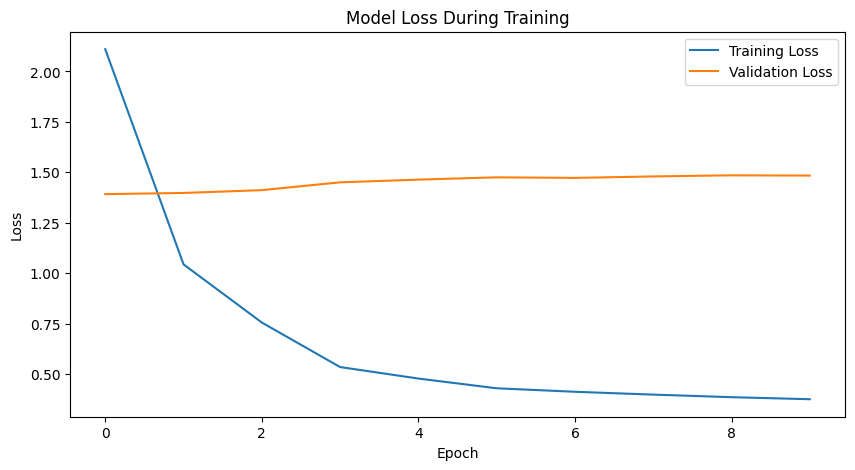

In [8]:
import matplotlib.pyplot as plt

# Assuming 'history' is your History object from Keras after fitting
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [9]:
# Rebuild the model architecture
model = Model(inputs=list(inputs.values()), outputs=output)

# Load the best model weights from the updated checkpoint path
model.load_weights("/kaggle/working/best_model.keras")

# Now you can use the model to predict
y_pred = model.predict([X_test[col] for col in X.columns])
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

1931/1931 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Mean Squared Error: 1.385820846566109


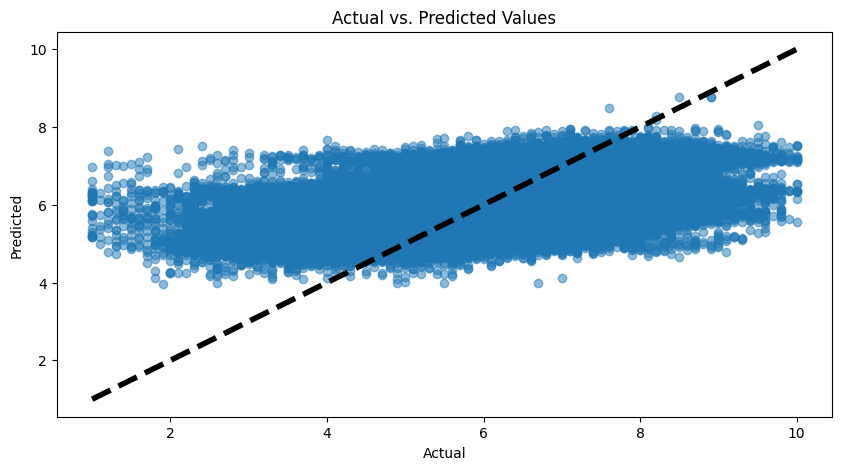

In [10]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()

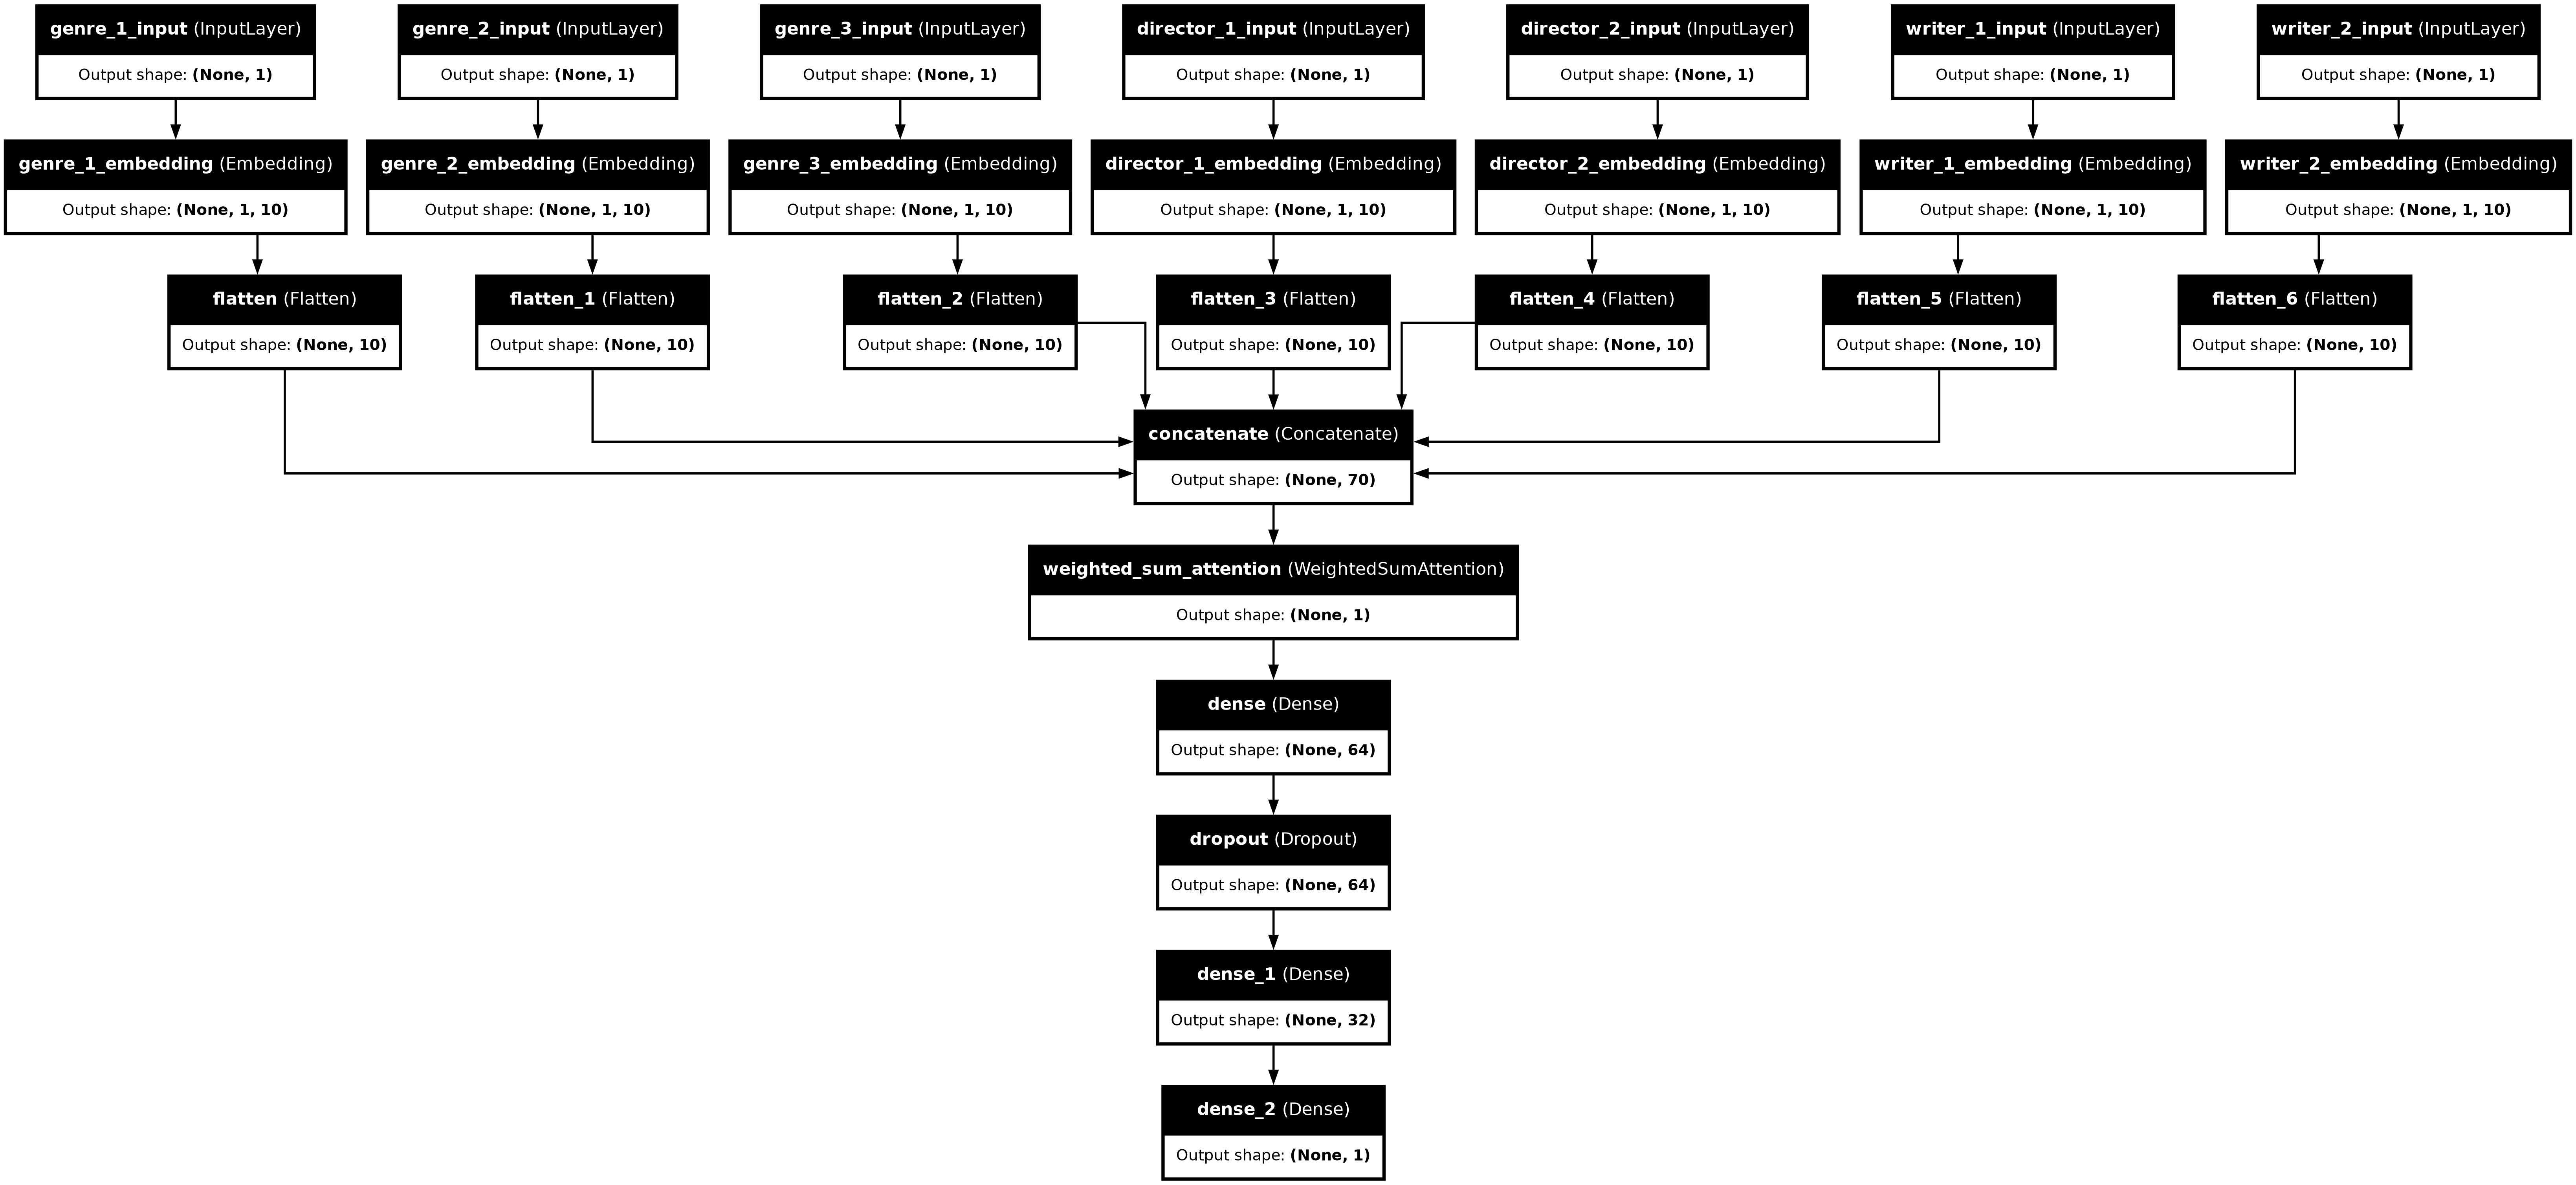

In [12]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your Keras model object from the build_model function
model = Model(inputs=list(inputs.values()), outputs=output) # build_model should be defined as in previous discussions

# Visualize the model
plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)

# Optionally, display the image in the notebook (if you're using Jupyter or similar)
from IPython.display import Image
Image(filename='model_diagram.png')

After training, the model is evaluated using the test data (X_test and y_test). The mean squared error (MSE) between the actual and predicted movie ratings is computed to quantify the model's performance. In this case, the MSE value is approximately 1.40, indicating the average squared difference between the predicted and actual ratings.

### Recommendation Model

The following recommendation model code implements a collaborative filtering approach to generate movie recommendations based on similarities between movies in terms of their genre, directors, and average ratings. The process begins with preprocessing the dataset, where relevant features such as encoded genre, encoded directors, and average rating are selected from the 'merged_df' dataset. A subset of movie data is sampled for training purposes to reduce computational complexity and memory usage. Using these selected features, a cosine similarity matrix is computed to quantify the similarity between pairs of movies. Subsequently, a function is defined to generate movie recommendations for a given movie title, leveraging the computed similarity matrix to identify and rank similar movies. The model's performance is evaluated using mean squared error (MSE) as the evaluation metric, comparing predicted ratings with actual ratings on a test subset of the dataset. Finally, the model is tested on a reduced randomly sampled subset of the dataset, allowing for efficient testing while still capturing essential patterns in the data. This approach offers a systematic framework for building a collaborative filtering-based recommendation system tailored to movie preferences, enhancing user experience by providing personalized and contextually relevant movie suggestions.

In [13]:
y_pred_full = model.predict([X[col] for col in X.columns])
merged_df['predicted_averageRating'] = y_pred_full.flatten()

9655/9655 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step


In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Sample a reduced subset of the dataset for both training and testing
sampled_df = merged_df.sample(frac=0.01, random_state=42)  # Adjust the fraction as needed

# Step 1: Preprocess the data
# Select relevant features: encoded_genre, encoded_directors, averageRating
selected_features = sampled_df[['encoded_genre_1', 'encoded_genre_2', 'encoded_genre_3', 'encoded_director_1', 'encoded_director_2', 'encoded_writer_1', 'encoded_writer_2', 'predicted_averageRating']]

# Sample a subset of movie titles for training
sampled_data = selected_features.sample(n=1000, random_state=42)  # Adjust the sample size as needed

# Combine selected features
X_train = sampled_data.values

In [15]:
# # Step 2: Compute similarity matrix
# similarity_matrix_train = cosine_similarity(X_train, X_train)

In [16]:
import pandas as pd

def get_movie_recommendations(movie_title, similarity_df):
    # Check if the movie title exists in the DataFrame to avoid KeyError
    if movie_title in similarity_df.index:
        # Retrieve similarity scores for the specified movie title directly using its label
        similarity_scores = similarity_df.loc[movie_title]

        # Sort the scores in descending order and get the top n similar movies
        top_titles = similarity_scores.sort_values(ascending=False)[1:6]  # Skip the first one (itself)

        # Return a DataFrame with the movie titles and their corresponding similarity scores
        recommendations = pd.DataFrame({
            'Movie': top_titles.index,
            'Similarity': top_titles.values
        })
        return recommendations
    else:
        print(f"Movie titled '{movie_title}' not found.")
        return pd.DataFrame()

In [17]:
# Step 4: Evaluate the model
def evaluate_model(predictions, actual):
    mse = mean_squared_error(actual, predictions)
    return mse

In [18]:
# Step 5: Split the data into training and test sets
train_data, test_data = train_test_split(sampled_df, test_size=0.2, random_state=42)

In [19]:
# Step 6: Compute similarity matrix using training data
from sklearn.metrics.pairwise import cosine_similarity

X_train = train_data[['encoded_genre_1', 'encoded_genre_2', 'encoded_genre_3', 'encoded_director_1','encoded_director_2', 'encoded_writer_1','encoded_writer_2','averageRating']].values

def batch_cosine_similarity(X, batch_size=5):
    # Compute the cosine similarity in batches to avoid memory issues
    sim_matrix = np.zeros((X.shape[0], X.shape[0]))
    for start in range(0, X.shape[0], batch_size):
        end = start + batch_size
        sim_matrix[start:end] = cosine_similarity(X[start:end], X)
    return sim_matrix

similarity_matrix_train = batch_cosine_similarity(X_train)

In [20]:
import pandas as pd

# Create a DataFrame for the similarity matrix with titles as row and column indices
titles = train_data['primaryTitle'].values  # Assuming 'originalTitle' contains the titles
similarity_df = pd.DataFrame(similarity_matrix_train, index=titles, columns=titles)

In [22]:
if not train_data.empty:
    movie_title = train_data['primaryTitle'].iloc[1]
    print("Movie title in the dataset:", movie_title)
else:
    print("The dataset is empty.")

Movie title in the dataset: Bounce Ko Gals


In [23]:
# # Step 7: Generate recommendations for a specific movie title
movie_title = "Bounce Ko Gals"  # Example movie title
recommendations = get_movie_recommendations(movie_title, similarity_df)
if not recommendations.empty:
    print("Recommendations for movie:", movie_title)
    print(recommendations)
else:
    print(f"No recommendations available for '{movie_title}'.")

Recommendations for movie: Bounce Ko Gals
                 Movie  Similarity
0     Hassan, the Bald    0.999991
1           Greek Pete    0.999989
2             I Belong    0.999989
3       A Stasi Comedy    0.999987
4  First Class Thieves    0.999985
